## 1. Chargement des Données Nettoyées

On charge le fichier CSV créé à la fin du notebook EDA.

In [9]:
# Imports nécessaires
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Optionnel: pour scaler les features si besoin
# from sklearn.preprocessing import StandardScaler

In [3]:
# Chemin vers le fichier nettoyé
CLEAN_FILE_PATH = 'TMDB_cleaned_data.csv'

print(f"Chargement des données nettoyées depuis: {CLEAN_FILE_PATH}")
try:
    df_model = pd.read_csv(CLEAN_FILE_PATH)
    print("Chargement réussi.")
    print(f"Shape des données pour la modélisation: {df_model.shape}")
    display(df_model.head(3))
except FileNotFoundError:
    print(f"Erreur: Le fichier {CLEAN_FILE_PATH} n'a pas été trouvé.")
    print("Assurez-vous d'avoir exécuté le notebook EDA_Films.ipynb et sauvegardé le fichier.")
    df_model = pd.DataFrame() # Dataframe vide pour éviter erreurs

Chargement des données nettoyées depuis: TMDB_cleaned_data.csv
Chargement réussi.
Shape des données pour la modélisation: (14853, 18)


,title,vote_average,vote_count,release_date,revenue,runtime,budget,homepage,imdb_id,original_language,genres,production_companies,production_countries,spoken_languages,release_year,release_month,log_revenue,genre_list
0,Inception,8.364,34495,2010-07-15,825532764,148,160000000,https://www.warnerbros.com/movies/inception,tt1375666,en,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili",2010,7,20.531540,"['Action', 'Science Fiction', 'Adventure']"
1,Interstellar,8.417,32571,2014-11-05,701729206,169,165000000,http://www.interstellarmovie.net/,tt0816692,en,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,2014,11,20.369058,"['Adventure', 'Drama', 'Science Fiction']"
2,The Dark Knight,8.512,30619,2008-07-16,1004558444,152,185000000,https://www.warnerbros.com/movies/dark-knight/,tt0468569,en,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin",2008,7,20.727814,"['Drama', 'Action', 'Crime', 'Thriller']"


## 2. Préparation des Données pour la Modélisation

- Sélection des caractéristiques (Features) et de la variable cible (Target).
- Séparation des données en ensembles d'entraînement et de test.

**Note:** Pour cette version WIP, nous utilisons uniquement les caractéristiques numériques simples identifiées dans l'EDA.


In [4]:
if not df_model.empty:
    # Sélection des caractéristiques numériques pertinentes
    # 'revenue' est exclu car 'log_revenue' est la cible.
    # 'release_year' et 'release_month' sont gardés.
    features = ['runtime', 'vote_average', 'vote_count', 'release_year', 'release_month']
    target = 'log_revenue'

    # Vérifier si toutes les features existent
    missing_features = [f for f in features if f not in df_model.columns]
    if missing_features:
        print(f"Erreur: Colonnes features manquantes: {missing_features}")
        # Arrêter ou adapter la liste features
        features = [f for f in features if f in df_model.columns]
        print(f"Utilisation des features restantes: {features}")

    if target not in df_model.columns:
         print(f"Erreur: Colonne target '{target}' manquante!")
         # Arrêter ici
         X = pd.DataFrame()
         y = pd.Series()
    elif not features:
        print("Erreur: Aucune colonne feature valide sélectionnée.")
        X = pd.DataFrame()
        y = pd.Series()
    else:
        # Gestion des NaN potentiels (même si nettoyé, par sécurité)
        df_model = df_model[features + [target]].dropna()
        print(f"Shape après suppression des NaNs dans les colonnes sélectionnées: {df_model.shape}")

        X = df_model[features]
        y = df_model[target]

        # Séparation Train / Test
        # random_state pour la reproductibilité
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"Taille de l'ensemble d'entraînement (X): {X_train.shape}")
        print(f"Taille de l'ensemble de test (X): {X_test.shape}")

        # Optionnel: Standardisation des features (souvent utile pour LinearRegression)
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_test_scaled = scaler.transform(X_test)
        # print("Features standardisées (commenté pour l'instant).")

else:
    print("Skipping data preparation due to empty dataframe.")
    X_train, X_test, y_train, y_test = (pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series())


Shape après suppression des NaNs dans les colonnes sélectionnées: (14853, 6)
Taille de l'ensemble d'entraînement (X): (11882, 5)
Taille de l'ensemble de test (X): (2971, 5)


## 3. Entraînement et Évaluation des Modèles

On entraîne deux modèles simples :
1.  **Régression Linéaire:** Un modèle de base simple et interprétable.
2.  **Random Forest Regressor:** Un modèle d'ensemble plus puissant, capable de capturer des non-linéarités.

On évalue avec les métriques : RMSE, MAE, R².

In [6]:
# Dictionnaire pour stocker les résultats
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Fonction pour entraîner et évaluer un modèle."""
    print(f"--- Entraînement et Évaluation: {name} ---")
    try:
        # Utiliser X_train standardisé si activé: model.fit(X_train_scaled, y_train)
        model.fit(X_train, y_train)
        # Utiliser X_test standardisé si activé: y_pred = model.predict(X_test_scaled)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")

        results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'model': model}
        print("-------------------------------------------\n")
        return results
    except Exception as e:
        print(f"Erreur pendant l'évaluation de {name}: {e}")
        print("-------------------------------------------\n")
        return results

### 3.1 Modèle 1 : Régression Linéaire

In [7]:
if not X_train.empty:
    lr_model = LinearRegression()
    results = evaluate_model("Régression Linéaire", lr_model, X_train, y_train, X_test, y_test)
else:
    print("Skipping Linear Regression (no data).")

--- Entraînement et Évaluation: Régression Linéaire ---
RMSE: 2.3422
MAE: 1.8796
R²: 0.2923
-------------------------------------------



### 3.2 Modèle 2 : Random Forest Regressor

In [8]:
if not X_train.empty:
    # Utiliser des paramètres simples pour un test rapide
    rf_model = RandomForestRegressor(n_estimators=100, # Nombre d'arbres
                                     random_state=42,
                                     n_jobs=-1,       # Utiliser tous les CPU disponibles
                                     max_depth=15,    # Limiter la profondeur pour éviter l'overfitting / temps long
                                     min_samples_leaf=5 # Nombre min d'échantillons par feuille
                                     )
    results = evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)
else:
    print("Skipping Random Forest (no data).")

--- Entraînement et Évaluation: Random Forest ---
RMSE: 1.8262
MAE: 1.3534
R²: 0.5698
-------------------------------------------



## 4. Comparaison des Modèles

Tableau comparatif des performances:


,RMSE,MAE,R2
Random Forest,1.826178,1.353428,0.569777
Régression Linéaire,2.342215,1.879638,0.292281


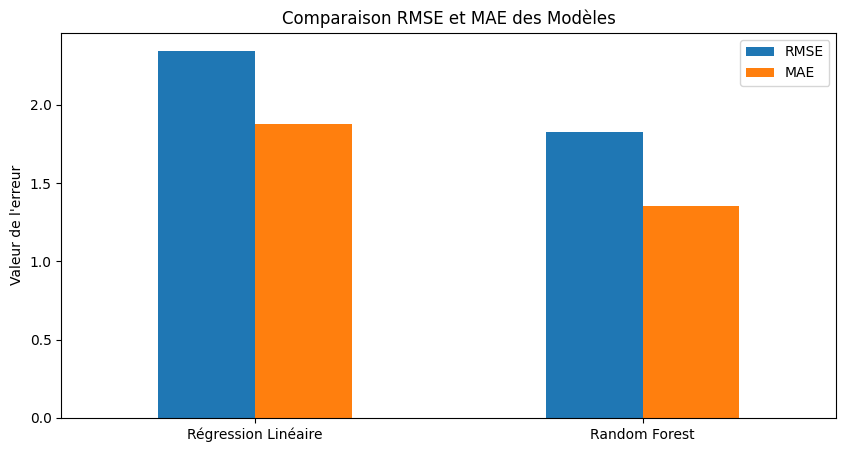

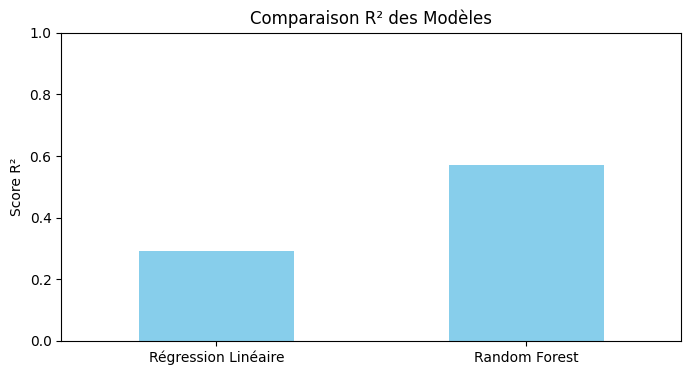

In [10]:
if results:
    results_df = pd.DataFrame.from_dict(results, orient='index').drop(columns='model')
    print("Tableau comparatif des performances:")
    display(results_df.sort_values(by='RMSE')) # Trier par RMSE (plus bas est mieux)

    # Visualisation rapide des performances
    results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 5))
    plt.title('Comparaison RMSE et MAE des Modèles')
    plt.ylabel('Valeur de l\'erreur')
    plt.xticks(rotation=0)
    plt.show()

    results_df['R2'].plot(kind='bar', figsize=(8, 4), color='skyblue')
    plt.title('Comparaison R² des Modèles')
    plt.ylabel('Score R²')
    plt.xticks(rotation=0)
    plt.ylim(0, 1) # R² est entre 0 et 1 (ou négatif si très mauvais)
    plt.show()
else:
    print("Aucun résultat de modèle à comparer.")

## 5. Conclusion (Préliminaire)

Cette première étape de modélisation montre les performances de base d'une Régression Linéaire et d'un Random Forest en utilisant uniquement des caractéristiques numériques simples.

**Constats (à remplir en fonction des résultats réels obtenus):**
- Le modèle [Nom du meilleur modèle, ex: Random Forest] semble plus performant sur la base des métriques [ex: RMSE et R²].
- Le score R² de [valeur R² du meilleur modèle] indique que le modèle explique environ [valeur R² * 100]% de la variance de `log_revenue` dans l'ensemble de test, en utilisant *seulement* ces quelques features.

**Prochaines Étapes Possibles:**
1.  **Ingénierie de caractéristiques plus poussée:**
    - Encoder les variables catégorielles (`genres`, `production_companies`, `production_countries`, `spoken_languages`). One-Hot Encoding, Target Encoding pourraient être testés.
    - Extraire des informations du texte (`title`, `keywords`?) via TF-IDF ou Embeddings.
    - Créer des features d'interaction.
2.  **Optimisation des Modèles:**
    - Utiliser la validation croisée (Cross-Validation) pour une évaluation plus robuste.
    - Optimiser les hyperparamètres des modèles (ex: `n_estimators`, `max_depth` pour Random Forest) via GridSearchCV ou RandomizedSearchCV.
3.  **Explorer d'autres modèles:** Gradient Boosting (XGBoost, LightGBM), réseaux de neurones simples.
4.  **Analyse des erreurs:** Examiner où les modèles se trompent le plus.